In [28]:
#testing!
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# Load the datasets
file1_path = 'educ_data.csv'
file2_path = 'gini_data.csv'
file3_path = 'unemp_data.csv'

educ_df = pd.read_csv(file1_path)
gini_df = pd.read_csv(file2_path)
unemp_df = pd.read_csv(file3_path)

In [29]:
# Clean unemp_df
id_vars = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']  
year_columns = unemp_df.columns[4:]  # All the year columns, starting from the 5th column onward

# Melt the dataframe to bring year columns into rows
unemp_df = pd.melt(unemp_df, id_vars=id_vars, value_vars=year_columns, var_name='Year', value_name='Unemp %')

# Drop rows with no data
unemp_df = unemp_df.dropna(subset=['Unemp %'])

# Convert 'Year' to a numerical type if needed (strip out the text around it, like 'YR1960' to just '1960')
unemp_df['Year'] = unemp_df['Year'].str.extract('(\d+)').astype(int)

# Clean educ_df
id_vars = ['Country Name', 'Country Code', 'Series Name', 'Series Code']  
year_columns = educ_df.columns[4:]  # All the year columns, starting from the 5th column onward

# Melt the dataframe to bring year columns into rows
educ_df = pd.melt(educ_df, id_vars=id_vars, value_vars=year_columns, var_name='Year', value_name='Average years of schooling')

# Drop rows with no data
educ_df = educ_df[educ_df['Average years of schooling'] != '..']

# Convert 'Year' to a numerical type if needed (strip out the text around it, like 'YR1960' to just '1960')
educ_df['Year'] = educ_df['Year'].str.extract('(\d+)').astype(int)

# Clean gini_df

gini_df["iso"] = gini_df["iso"].transform(lambda x: x.upper())
gini_df['gini_recalculated'] = pd.to_numeric(gini_df['gini_recalculated'], errors='coerce')
gini_df = gini_df.dropna(subset=['gini_recalculated'])

<>:12: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:12: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
C:\Users\sarah\AppData\Local\Temp\ipykernel_35176\2385620764.py:12: SyntaxWarning: invalid escape sequence '\d'
  unemp_df['Year'] = unemp_df['Year'].str.extract('(\d+)').astype(int)
C:\Users\sarah\AppData\Local\Temp\ipykernel_35176\2385620764.py:25: SyntaxWarning: invalid escape sequence '\d'
  educ_df['Year'] = educ_df['Year'].str.extract('(\d+)').astype(int)


In [30]:
merged_df = pd.merge(gini_df,unemp_df,left_on=["iso","year"],right_on=["Country Code","Year"])
merged_df = pd.merge(merged_df,educ_df,left_on=["iso","year"],right_on=["Country Code","Year"])

columns_req = ['country', 'iso', 'year', 'gini_reported',
       'gdp_ppp_pc_usd2011', 'population',
       'gini_recalculated','Unemp %',
       'Series Name','Average years of schooling']

merged_df = merged_df[columns_req]
merged_df = merged_df[merged_df['Series Name'].str.contains('both sexes', case=False)]

# Step 2: Drop duplicate rows
merged_df = merged_df.drop_duplicates().reset_index(drop=True)
merged_df = merged_df.set_index(["country","year"])


In [31]:
print(merged_df)

                   iso gini_reported  gdp_ppp_pc_usd2011    population  \
country      year                                                        
Angola       2014  AGO     0.4445348         6283.000000  2.254955e+07   
Albania      2001  ALB   0.329893478         5845.833333  3.121602e+06   
             2008  ALB   0.319450431         8986.000000  3.002683e+06   
             2011  ALB   0.312414251         9987.250000  2.936239e+06   
             2012  ALB   0.310068857        10321.000000  2.914091e+06   
...                ...           ...                 ...           ...   
South Africa 2015  ZAF     0.6496464        12367.000000  5.529122e+07   
Zimbabwe     1992  ZWE        0.6392         2836.600000  1.063801e+07   
             2002  ZWE     0.6164938         2401.438000  1.266185e+07   
             2012  ZWE     0.4499857         1943.000000  1.438665e+07   
             2014  ZWE     0.4499857         1943.000000  1.438665e+07   

                   gini_recalculated 

## 2. Using the ARIMA model for forecasting inequality
ARIMA is a model used for time series forecasting, and we can use this to forecast inequality in various countries.

In order to find the best model for forecasting, we need to determine the parameters of the ARIMA model, namely:

**p: the number of autoregressive terms**

**d: the number of nonseasonal differences needed for stationarity**

**q: the number of lagged forecast errors in the prediction equation.**

### 2.1. Determining parameter d, the number of nonseasonal differences for stationarity

To use an ARIMA model, we need to ensure that the data is stationary by determining and eliminating seasonality by selecting an appropriate parameter d.

The parameter d is the "degree of differencing", which refers to the number of times a series is differenced. For example, if the series value is X_t, then 1 degree of differencing means the new value X_t' = X_t - X_t-1

We use both Autocorrelation Function (ACF) graphs and Augmented Dicky-Fuller tests to determine the number of differences needed (value of d).

#### 2.1.1 ACF graphs allow us to visualise the autocorrelation and hence seasonality

We will start by doing the analysis on Singapore, before conducting it across all countries.

In [32]:
# Clean gini_df
gini_columns_req = ['country', 'iso', 'year', 'gini_recalculated']

gini_df_clean = gini_df[gini_columns_req]
gini_df_clean = gini_df_clean.drop_duplicates().reset_index(drop=True)
gini_df_clean = gini_df_clean.set_index('year')

# Create singapore_df
singapore_df = gini_df_clean.loc[gini_df_clean['country']=='Singapore'].copy()
singapore_df.head()

,country,iso,gini_recalculated
year,,,
1967,Singapore,SGP,0.399908
1968,Singapore,SGP,0.399908
1969,Singapore,SGP,0.399908
1970,Singapore,SGP,0.399908
1971,Singapore,SGP,0.399908


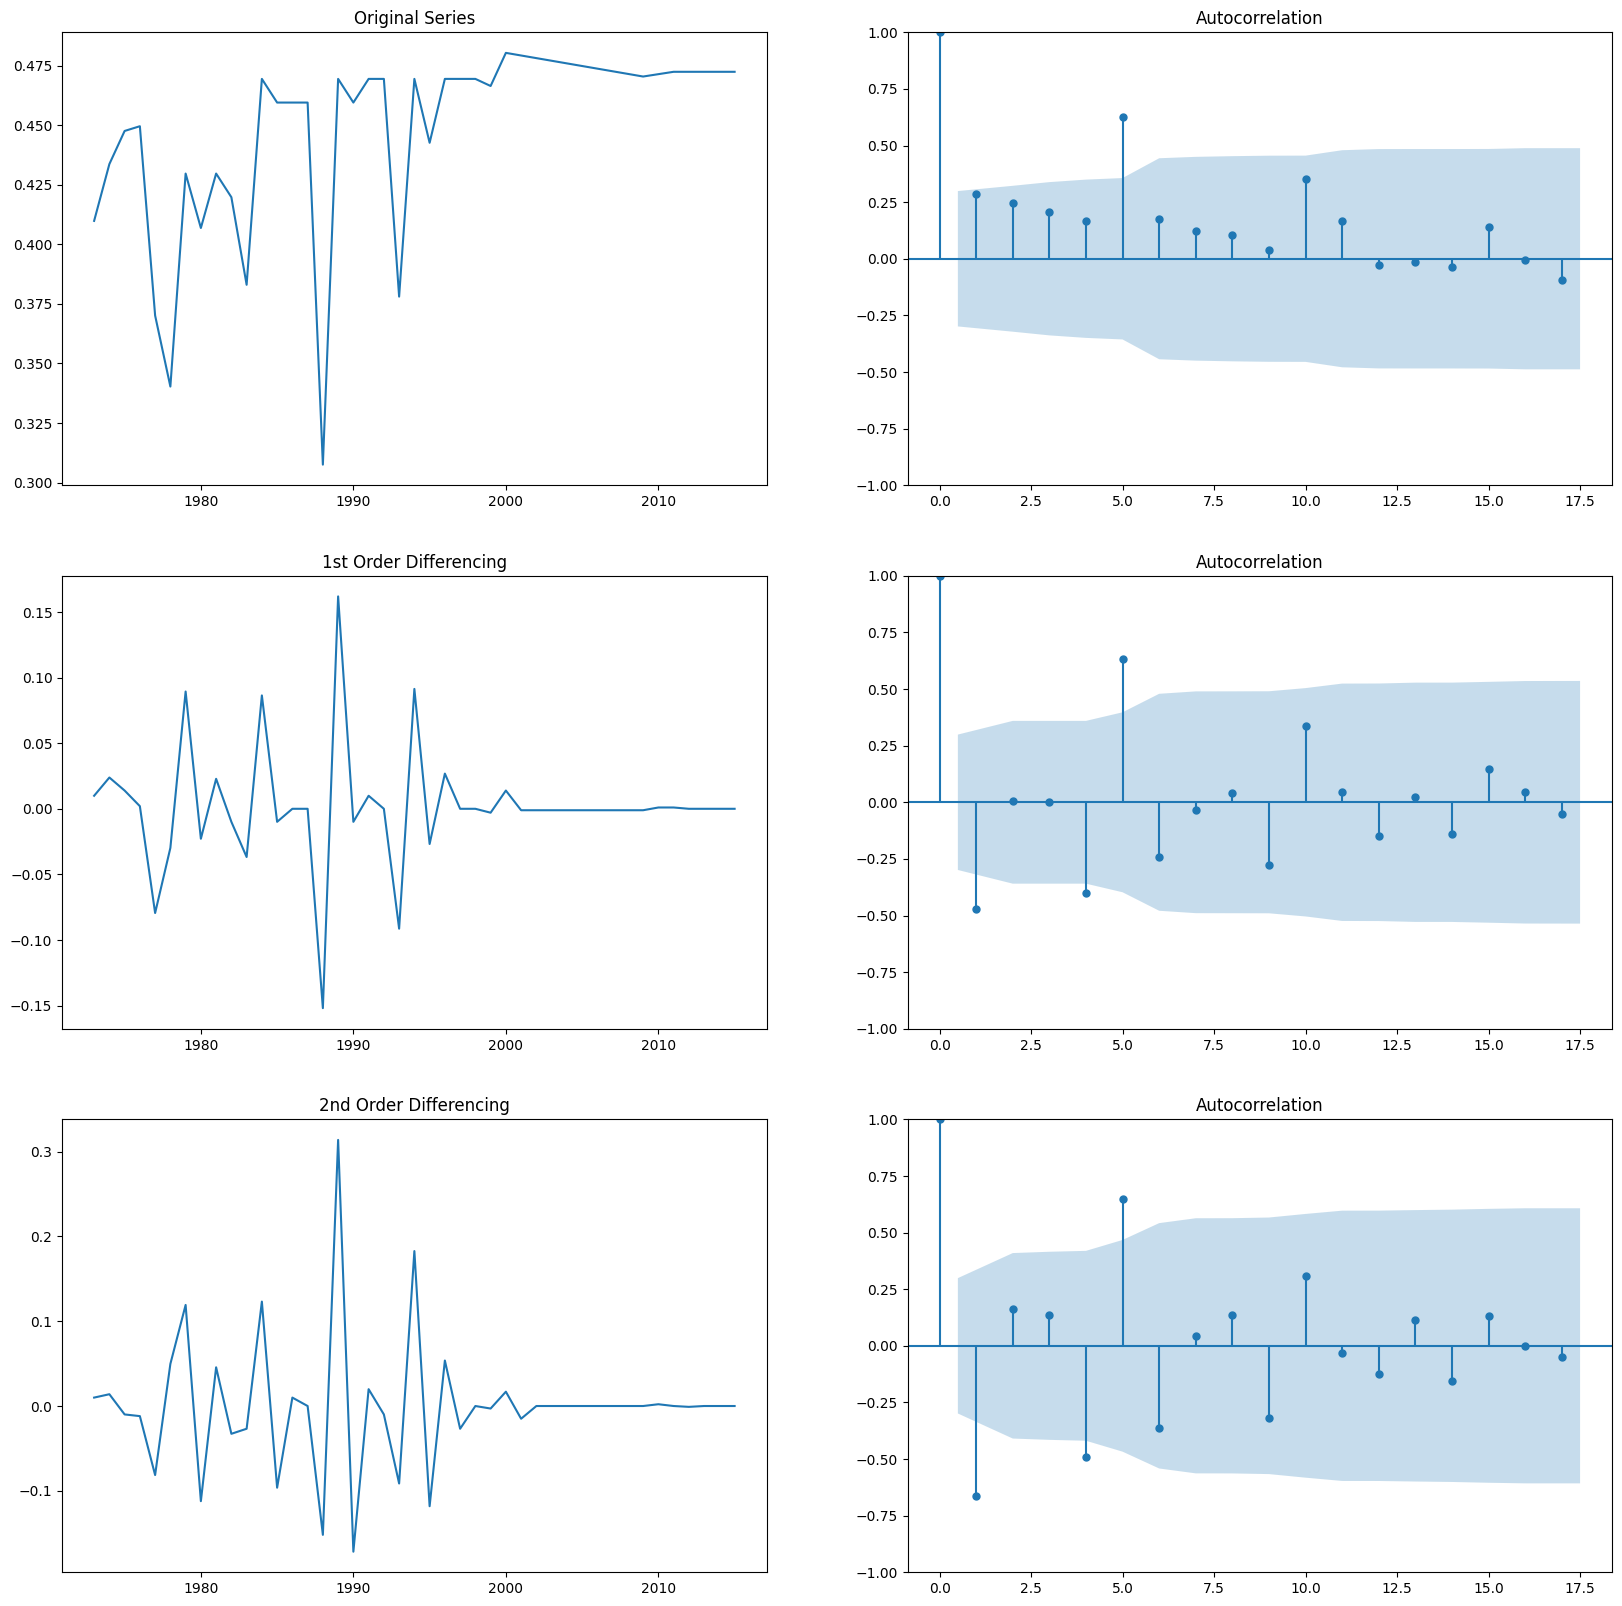

In [40]:
#Plotting ACF graphs

from statsmodels.graphics.tsaplots import plot_acf

# Create dataframes for d = 1 and d = 2 values of gini_recalculated
singapore_df['gini_recalculated_d1'] = singapore_df['gini_recalculated'].diff()
singapore_df['gini_recalculated_d2'] = singapore_df['gini_recalculated'].diff().diff()
singapore_df.dropna(inplace=True)

# Original Series
fig, axes = plt.subplots(3, 2, figsize=(20,20))
axes[0, 0].plot(singapore_df['gini_recalculated'])
axes[0, 0].set_title('Original Series')
plot_acf(singapore_df['gini_recalculated'], ax=axes[0,1])

# 1st Differencing
axes[1, 0].plot(singapore_df['gini_recalculated_d1']); axes[1, 0].set_title('1st Order Differencing')
plot_acf(singapore_df['gini_recalculated_d1'], ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(singapore_df['gini_recalculated_d2']); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(singapore_df['gini_recalculated_d2'], ax=axes[2, 1])

plt.show()

The goal of differencing is to reduce autocorrelation trends to obtain stationarity. As seen from the ACF graphs above, d = 0  appears to have a gradual decline on autocorrelation, which is typical when the data is not stationary.

The ACF graph for d = 1 still shows some autocorrelation, but without any trend. Since d = 2 does not change much from d = 1, we will likely use d = 1 to prevent over-differencing.

#### 2.1.2. Augmented Dicky Fuller (ADF) Test
The ADF test is a numerical test for stationarity, to confirm our conclusions from the ACF graph.

In [44]:
#Calculating p-values for Augmented Dicky-Fuller (adfuller) Tests
from statsmodels.tsa.stattools import adfuller

gini_d0 = singapore_df['gini_recalculated'].tolist()
gini_d1 = singapore_df['gini_recalculated_d1'].tolist()
gini_d2 = singapore_df['gini_recalculated_d2'].tolist()

print('The p-value of adfuller test for d = 0 is:', adfuller(gini_d0)[1])
print('The p-value of adfuller test for d = 1 is:', adfuller(gini_d1)[1])
print('The p-value of adfuller test for d = 2 is:', adfuller(gini_d2)[1])


The p-value of adfuller test for d = 0 is: 0.7622286107199998
The p-value of adfuller test for d = 1 is: 1.1320381083234134e-16
The p-value of adfuller test for d = 2 is: 1.26604080436944e-12


Since the p-value of the adfuller test is <<> 0.01 for d = 1, we will use d = 1 in our ARIMA model, which supports our initial hypothesis from the ACF graphs.